In [1]:
# aim : predict earnings for foreign movies in the US
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
import scraping
import constants
import os
import numpy as np
import re
import seaborn as sns
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from seaborn import plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection  import KFold
from sklearn import preprocessing

import scipy.stats as stats
import patsy
import statsmodels.api as sm
%matplotlib inline

In [2]:
df = pd.read_csv('data/data_salary.csv', index_col=0)

In [3]:
df = df.dropna()

# Adjust for inflation


In [4]:
with open ('data/inflation_multiplier.pkl', 'rb') as fp:
    inflation_mult = pickle.load(fp)

In [5]:
df['inflation'] = df['draft_year'].map(inflation_mult)

In [6]:
df['adjusted_salary'] = df['inflation'] * df['salary']

In [7]:
df.birthday = pd.to_datetime(df.birthday)

In [8]:
df['month'] = df.birthday.dt.month

In [9]:
def basic_plot(x_col, y_col, df, ax, x_label=None, y_label=None):
    if not x_label:
        x_label = x_col 
    if not y_label:
        y_label = y_col
    ax.scatter(df[x_col], df[y_col], label=y_label)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title('{} vs. {}'.format(x_label, y_label))
    

In [10]:
df.loc[df.position.str.contains('Center'), 'center'] = 1
df.loc[~df.position.str.contains('Center'), 'center'] = 0
df.loc[df.position.str.contains('Guard'), 'guard'] = 1
df.loc[~df.position.str.contains('Guard'), 'guard'] = 0
df.loc[df.position.str.contains('Forward'), 'forward'] = 1
df.loc[~df.position.str.contains('Forward'), 'forward'] = 0

In [11]:
df[df.name == 'Michael Jordan'][['name', 'adjusted_salary','draft_rank', 'per','draft_year',]]

,name,adjusted_salary,draft_rank,per,draft_year
1045,Michael Jordan,1270500.0,3.0,27.9,1984.0


In [12]:
df.columns

Index(['ast', 'ast_per_g', 'blk', 'college', 'draft_rank', 'draft_year',
       'end_age', 'fg', 'fg3', 'fg3_pct', 'fg3a', 'fg_pct', 'fga', 'ft',
       'ft_pct', 'fta', 'g', 'height_in', 'mp', 'mp_per_g', 'name',
       'name_index', 'no_of_seasons', 'per', 'pts', 'pts_per_g', 'reach_in',
       'start_age', 'stl', 'trb_per_g', 'weight_lb', 'wingspan_in', 'salary',
       'position', 'birthday', 'shoot', 'inflation', 'adjusted_salary',
       'month', 'center', 'guard', 'forward'],
      dtype='object')

# Regularization

In [13]:
# The numerical columns
x_columns = ['ast', 'ast_per_g', 'blk', 'draft_rank', 'draft_year',
       'end_age', 'fg', 'fg3', 'fg3_pct', 'fg3a', 'fg_pct', 'fga', 'ft',
       'ft_pct', 'fta', 'g', 'height_in', 'mp', 'mp_per_g',
       'no_of_seasons', 'pts', 'pts_per_g', 'reach_in',
       'start_age', 'stl', 'trb_per_g', 'weight_lb', 'wingspan_in',
        'adjusted_salary', 'month'] # need to add shoot and position
def preprocess(df, cols = None, intercept=False):
    if not cols:
        cols = x_columns
    y_data = df['per']
    X_data = df[cols]
    X_sc=preprocessing.normalize(X_data, axis=0, norm='max')
    # turn back in DF
    X_sc=pd.DataFrame(X_sc)
    X_sc.columns = cols
    X_data.columns = cols
    return X_sc, y_data, X_data

In [14]:
folds = 4
alpha_list=[1e-5,1e-3,1e-2, 1e-1,1, 10, 1e4]
def pick_alpha(fold, X, y, alphas=None):
    if not alphas:
        alphas = alpha_list
    kf = KFold(n_splits=fold)

    all_scores=[]


    for train, test in kf.split(X):
        x_train=X.iloc[train]
        y_train=y.iloc[train]
        x_test=X.iloc[test]
        y_test=y.iloc[test]
        mse_score=[]
        for a in alphas:
            est=Lasso(alpha=a)
            est.fit(x_train,y_train)
            mse=np.mean((y_test-est.predict(x_test))**2)
            mse_score.append(mse)
        all_scores.append(mse_score)
    plt.figure(figsize=(8,6))
    plt.legend()
    for i in range(fold):
        plt.plot(np.log10(alphas), all_scores[i],label = 'cv %s'%i)
    # Calculate the mean and plot it
    mean = np.array(all_scores).mean(axis=0).tolist()
    plt.plot(np.log10(alphas), mean, label = 'mean')
    plt.legend()
    plt.xlabel('alphas')
    plt.ylabel('MSE')
    plt.ylim(0)
    plt.show()

# First Iteration

/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


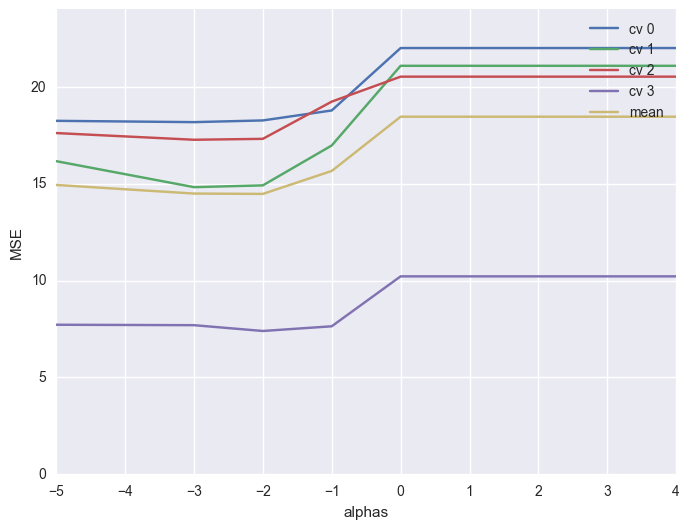

In [15]:
X_sc, y_data, X_data = preprocess(df)
pick_alpha(4, X_sc, y_data)

# Alpha
- It seems like 1e-2 is the best value
- Now, let's take a look at the strongest features

In [16]:
# Take a quick look at our strongest features
def find_features(alpha, X, y, columns):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    est=Lasso(alpha=alpha)
    est.fit(X_train,y_train)
    zipped=zip(columns,est.coef_)
    features=sorted(zipped,key = lambda t: t[1],reverse=True)
    print(est.score(X_test, y_test))
    return [x for x in features if x[1] != 0] ,est
def print_summary (features, X, y):
    features = [x[0] for x in features]
    X_features = X[features]
    lsm = sm.OLS(y,X_features)
    fit = lsm.fit()
    fit.summary()


In [17]:
features,est = find_features(1e-2, X_sc, y_data, X_sc.columns)

0.307936797645


In [18]:
features

[('fg_pct', 9.1097464347011972),
 ('adjusted_salary', 3.9172194400710687),
 ('stl', 2.8428576576333491),
 ('ft_pct', 1.9383010400473994),
 ('pts_per_g', 1.8616305204560277),
 ('blk', 1.547951957175276),
 ('trb_per_g', 1.3600278440487907),
 ('ast_per_g', 1.0138468673574206),
 ('ast', 0.61793066540312958),
 ('mp', 0.50513535458189363),
 ('month', -0.31020759914789847),
 ('weight_lb', -0.34019008147650515),
 ('fg3a', -1.2755900902600199),
 ('g', -2.113988715655053),
 ('draft_rank', -4.2761455249321445),
 ('end_age', -5.8621284875073885)]

In [158]:
def print_coef(f, coef):
    zipped=zip(f,coef)
    features=sorted(zipped,key = lambda t: t[1],reverse=True)
    for (a,b) in features:
        print ('{}\t\t\t{}'.format(a,b))


#  Without adjusted salary
## Unscaled

In [166]:
rcv = RidgeCV(cv=10)
f = [x[0] for x in features]
if 'adjusted_salary' in f:
    f.remove('adjusted_salary')
X_sc, y_data, X_data = preprocess(df, cols=f)
xtrain, xtest, ytrain, ytest = train_test_split(X_data, y, test_size=0.3)

rcv.fit(X_data, y)
rcv.score(xtest, ytest)


0.23438215742178292

In [167]:
rcv.intercept_

13.640229113092689

In [168]:
print_coef(f, rcv.coef_)

fg_pct			19.662222163529883
ft_pct			4.858292255325513
ast_per_g			0.2188401169825615
trb_per_g			0.18880680043523182
pts_per_g			0.03217625872069718
stl			0.011508641942250966
blk			0.005633734570636035
fg3a			-0.0007388359305236035
weight_lb			-0.010006467758676422
g			-0.016134496587202642
draft_rank			-0.059730009040545845
end_age			-0.6088984804754476


## Scaled

In [169]:
rcv = RidgeCV(cv=10)

xtrain, xtest, ytrain, ytest = train_test_split(X_sc, y, test_size=0.3)
rcv.fit(X_sc, y)
rcv.score(xtest, ytest)


0.35321396285880874

In [170]:
print_coef(f, rcv.coef_)

fg_pct			10.834557783473933
stl			3.852886180734736
ft_pct			3.6567048283351
blk			2.882406798667162
trb_per_g			2.2820048536165456
ast_per_g			1.8154701927651156
pts_per_g			1.499742366865473
fg3a			-1.3147051560507619
weight_lb			-2.419714897995886
g			-2.7410513558752547
draft_rank			-6.904973971359178
end_age			-9.5335798668147


In [171]:
rcv.intercept_

11.134064759509783

# With adjusted salary
## Unscaled

In [172]:
rcv = RidgeCV(cv=10)
f = [x[0] for x in features]
X_sc, y_data, X_data = preprocess(df, cols=f)
xtrain, xtest, ytrain, ytest = train_test_split(X_data, y, test_size=0.3)

rcv.fit(X_data, y)
rcv.score(xtest, ytest)


0.26044536285779651

In [173]:
rcv.intercept_

11.467385149652214

In [175]:
print_coef(f, rcv.coef_)

fg_pct			18.442821830597698
ft_pct			4.412257599617287
ast_per_g			0.16108479609778378
trb_per_g			0.15636947098507512
pts_per_g			0.048298173547996315
stl			0.011964366038838258
blk			0.004929634647750704
adjusted_salary			6.533868121174185e-07
fg3a			-0.0013237050764076102
weight_lb			-0.012611924551660575
g			-0.013184438334454282
draft_rank			-0.02868963913559157
end_age			-0.5175554253515836


## Scaled

In [176]:
rcs = RidgeCV(cv=10)
xtrain, xtest, ytrain, ytest = train_test_split(X_sc, y, test_size=0.3)
rcs.fit(X_sc, y)
rcs.score(xtest, ytest)

0.32511377045937012

In [177]:
print_coef(f, rcs.coef_)

fg_pct			10.109858915057917
adjusted_salary			4.0939933400345785
stl			4.06555931160913
ft_pct			3.2996470285924135
blk			2.472617828686838
pts_per_g			1.9276265121574678
trb_per_g			1.8585912373841984
ast_per_g			1.3336404117612237
fg3a			-1.9427793689288282
g			-2.171088959567595
weight_lb			-3.1409558439586602
draft_rank			-3.3542051322694224
end_age			-7.864409199420768


In [179]:
rcs.intercept_


9.1253150610280489